# Portfolio Optimization: Data Preparation and QUBO Formulation

This notebook implements the complete pipeline for formulating the **portfolio optimization problem with cardinality constraint** as a **Quadratic Unconstrained Binary Optimization (QUBO)** problem.

## Pipeline Overview

1. **Data Collection**: Download historical stock prices from Yahoo Finance
2. **Data Preprocessing**: Calculate returns and estimate covariance matrix
3. **QUBO Formulation**: Transform the portfolio problem into binary optimization
4. **Validation**: Verify numerical properties and save results

## Problem Definition

Given $n$ assets, select exactly $B$ assets to minimize risk while maximizing expected return:

$$\begin{align}
\text{minimize} \quad & \lambda \cdot w^T \Sigma w - \mu^T w \\
\text{subject to} \quad & \sum_{i=1}^n x_i = B \\
& w_i = \frac{x_i}{B} \quad \text{(equal-weighted)} \\
& x_i \in \{0, 1\}
\end{align}$$

where:
- $\lambda$: Risk aversion parameter
- $\Sigma$: Covariance matrix of returns
- $\mu$: Expected returns vector
- $B$: Number of assets to select (cardinality)

---

In [20]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os  # ← ADD THIS LINE

# Covariance estimation
from sklearn.covariance import LedoitWolf

# Data fetching
import yfinance as yf

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 1. Configuration and Data Collection

### Asset Selection

We select **21 large-cap US stocks** from diverse sectors:
- **Technology**: NVDA, MSFT, AAPL, AMZN, META, AVGO, GOOGL, TSLA
- **Finance**: JPM, V, MA, MS
- **Healthcare**: JNJ, UNH, TMO
- **Consumer**: WMT, PG, KO
- **Industrial**: CAT
- **Energy**: XOM
- **Telecommunications**: VZ

### Time Period

- **Start Date**: 2020-01-01
- **End Date**: 2023-12-31
- **Frequency**: Daily adjusted closing prices
- **Data Source**: Yahoo Finance (via yfinance)

In [7]:
# Configuration
TICKERS = [
    'NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA',
    'JPM', 'V', 'MA', 'XOM', 'JNJ', 'UNH', 'PG', 'WMT', 'MS', 'KO', 
    'CAT', 'VZ', 'TMO'
]

START_DATE = '2020-01-01'
END_DATE = '2023-12-31'
B = 4  # Cardinality: number of assets to select

print(f"Configuration:")
print(f"  Number of assets: {len(TICKERS)}")
print(f"  Cardinality (B): {B}")
print(f"  Time period: {START_DATE} to {END_DATE}")
print(f"  Tickers: {', '.join(TICKERS)}")

Configuration:
  Number of assets: 21
  Cardinality (B): 4
  Time period: 2020-01-01 to 2023-12-31
  Tickers: NVDA, MSFT, AAPL, AMZN, META, AVGO, GOOGL, TSLA, JPM, V, MA, XOM, JNJ, UNH, PG, WMT, MS, KO, CAT, VZ, TMO


## 2. Download Historical Price Data

We use `yfinance` to download adjusted closing prices, which account for stock splits and dividends.

In [9]:
print("\n🌐 Downloading data from Yahoo Finance...")
print(f"   Fetching {len(TICKERS)} tickers...")

try:
    # Download data
    raw_data = yf.download(
        TICKERS, 
        start=START_DATE, 
        end=END_DATE, 
        progress=False
    )
    
    # Debug: Check structure
    print(f"   Raw data shape: {raw_data.shape}")
    print(f"   Raw data columns type: {type(raw_data.columns)}")
    
    # Extract adjusted closing prices
    if len(TICKERS) == 1:
        # Single ticker case
        if 'Adj Close' in raw_data.columns:
            data = raw_data[['Adj Close']].copy()
            data.columns = TICKERS
        else:
            data = raw_data[['Close']].copy()
            data.columns = TICKERS
    else:
        # Multiple tickers case
        if isinstance(raw_data.columns, pd.MultiIndex):
            # New yfinance format: MultiIndex with (Price Type, Ticker)
            if 'Adj Close' in raw_data.columns.get_level_values(0):
                data = raw_data.xs('Adj Close', axis=1, level=0)
            else:
                data = raw_data.xs('Close', axis=1, level=0)
        else:
            # Flat structure (old format or single column)
            data = raw_data.copy()
    
    # Ensure we have a DataFrame
    if not isinstance(data, pd.DataFrame):
        data = data.to_frame()
    
    print(f"✓ Data downloaded successfully")
    print(f"  Shape: {data.shape} (days × assets)")
    print(f"  Date range: {data.index[0].date()} to {data.index[-1].date()}")
    print(f"  Columns: {list(data.columns[:5])}{'...' if len(data.columns) > 5 else ''}")
    
    # Verify all tickers are present
    missing_tickers = set(TICKERS) - set(data.columns)
    if missing_tickers:
        print(f"⚠️ Warning: Missing tickers: {missing_tickers}")
    
except Exception as e:
    print(f"✗ Error downloading data: {e}")
    print(f"\nTroubleshooting:")
    print(f"  1. Check internet connection")
    print(f"  2. Verify ticker symbols are valid")
    print(f"  3. Try updating yfinance: pip install --upgrade yfinance")
    import traceback
    traceback.print_exc()
    raise


🌐 Downloading data from Yahoo Finance...
   Fetching 21 tickers...
   Raw data shape: (1006, 105)
   Raw data columns type: <class 'pandas.core.indexes.multi.MultiIndex'>
✓ Data downloaded successfully
  Shape: (1006, 21) (days × assets)
  Date range: 2020-01-02 to 2023-12-29
  Columns: ['AAPL', 'AMZN', 'AVGO', 'CAT', 'GOOGL']...


## 3. Data Validation and Cleaning

Check for missing values and data quality issues.

In [10]:
print("\n🔍 Data Quality Check:")

# Check for missing values
missing = data.isnull().sum()
if missing.sum() > 0:
    print(f"⚠️ Missing values detected:")
    print(missing[missing > 0])
    print(f"\n  Filling missing values with forward fill method...")
    data = data.fillna(method='ffill').fillna(method='bfill')
else:
    print(f"✓ No missing values")

# Check for zero or negative prices
invalid_prices = (data <= 0).sum().sum()
if invalid_prices > 0:
    print(f"⚠️ Warning: {invalid_prices} zero or negative prices found")
else:
    print(f"✓ All prices are positive")

# Check data completeness
completeness = (1 - data.isnull().sum() / len(data)) * 100
print(f"\nData completeness per asset:")
for ticker in TICKERS:
    print(f"  {ticker:6s}: {completeness[ticker]:.2f}%")

print(f"\n✓ Data validation complete")


🔍 Data Quality Check:
✓ No missing values
✓ All prices are positive

Data completeness per asset:
  NVDA  : 100.00%
  MSFT  : 100.00%
  AAPL  : 100.00%
  AMZN  : 100.00%
  META  : 100.00%
  AVGO  : 100.00%
  GOOGL : 100.00%
  TSLA  : 100.00%
  JPM   : 100.00%
  V     : 100.00%
  MA    : 100.00%
  XOM   : 100.00%
  JNJ   : 100.00%
  UNH   : 100.00%
  PG    : 100.00%
  WMT   : 100.00%
  MS    : 100.00%
  KO    : 100.00%
  CAT   : 100.00%
  VZ    : 100.00%
  TMO   : 100.00%

✓ Data validation complete


## 4. Calculate Returns

We compute **daily log returns** for better statistical properties:

$$r_t = \log\left(\frac{P_t}{P_{t-1}}\right)$$

where $P_t$ is the adjusted closing price at time $t$.

In [12]:
# Calculate daily log returns
returns = np.log(data / data.shift(1)).dropna()

print(f"\n📊 Returns Statistics:")
print(f"  Shape: {returns.shape}")
print(f"  Trading days: {len(returns)}")
print(f"\nDaily returns (mean ± std):")
for ticker in TICKERS:
    mean_ret = returns[ticker].mean()
    std_ret = returns[ticker].std()
    print(f"  {ticker:6s}: {mean_ret:.6f} ± {std_ret:.6f}")

# Calculate annualized metrics for reference
mu_daily = returns.mean().values
sigma_daily = returns.std().values
mu_annual = 252 * mu_daily
sigma_annual = np.sqrt(252) * sigma_daily

print(f"\nAnnualized metrics (252 trading days):")
print(f"  Return range: [{mu_annual.min()*100:.2f}%, {mu_annual.max()*100:.2f}%]")
print(f"  Volatility range: [{sigma_annual.min()*100:.2f}%, {sigma_annual.max()*100:.2f}%]")


📊 Returns Statistics:
  Shape: (1005, 21)
  Trading days: 1005

Daily returns (mean ± std):
  NVDA  : 0.002104 ± 0.033944
  MSFT  : 0.000883 ± 0.020555
  AAPL  : 0.000963 ± 0.021137
  AMZN  : 0.000468 ± 0.023735
  META  : 0.000521 ± 0.029944
  AVGO  : 0.001363 ± 0.024265
  GOOGL : 0.000710 ± 0.021151
  TSLA  : 0.002148 ± 0.042906
  JPM   : 0.000306 ± 0.021644
  V     : 0.000335 ± 0.018885
  MA    : 0.000361 ± 0.021184
  XOM   : 0.000550 ± 0.023458
  JNJ   : 0.000178 ± 0.012977
  UNH   : 0.000642 ± 0.019278
  PG    : 0.000269 ± 0.013959
  WMT   : 0.000343 ± 0.014899
  MS    : 0.000706 ± 0.023674
  KO    : 0.000193 ± 0.014165
  CAT   : 0.000765 ± 0.021422
  VZ    : -0.000269 ± 0.013513
  TMO   : 0.000493 ± 0.018657

Annualized metrics (252 trading days):
  Return range: [-6.79%, 54.14%]
  Volatility range: [20.60%, 68.11%]


## 5. Visualize Returns and Correlations

Understanding the statistical properties of returns helps validate our data and identify diversification opportunities.

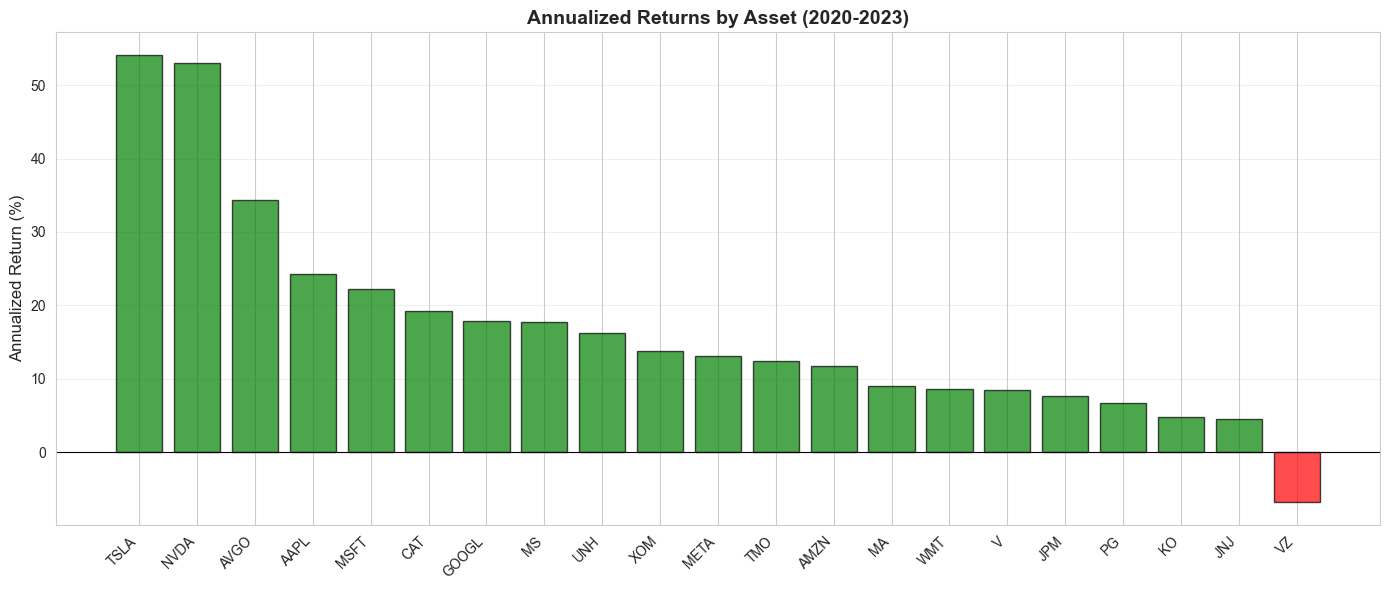

Best performer: TSLA (54.14%)
Worst performer: VZ (-6.79%)


In [13]:
# Calculate annualized returns and volatilities for plotting
annual_returns = 252 * returns.mean()
annual_vols = np.sqrt(252) * returns.std()

# Sort by returns
sorted_idx = annual_returns.sort_values(ascending=False).index

# Plot annualized returns
fig, ax = plt.subplots(figsize=(14, 6))
colors = ['green' if x > 0 else 'red' for x in annual_returns[sorted_idx]]
ax.bar(range(len(sorted_idx)), annual_returns[sorted_idx] * 100, color=colors, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(sorted_idx)))
ax.set_xticklabels(sorted_idx, rotation=45, ha='right')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_ylabel('Annualized Return (%)', fontsize=12)
ax.set_title('Annualized Returns by Asset (2020-2023)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Best performer: {annual_returns.idxmax()} ({annual_returns.max()*100:.2f}%)")
print(f"Worst performer: {annual_returns.idxmin()} ({annual_returns.min()*100:.2f}%)")


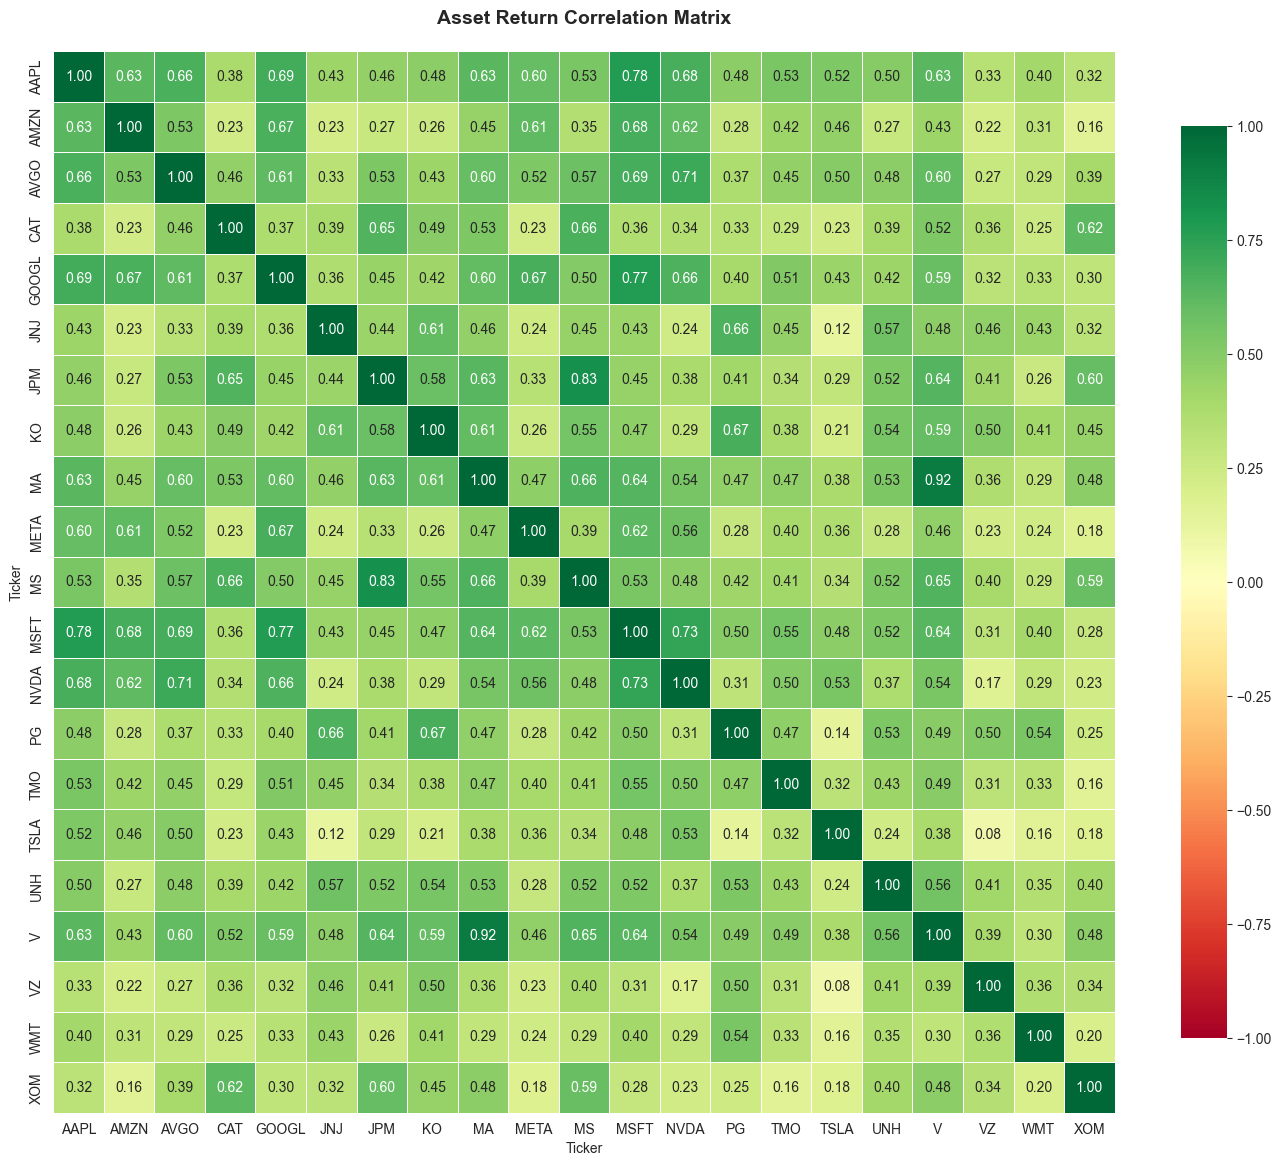


Correlation statistics:
  Average pairwise correlation: 0.441
  Min correlation: 0.080
  Max correlation: 0.917


In [14]:
# Calculate correlation matrix
correlation_matrix = returns.corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='RdYlGn', 
    center=0,
    vmin=-1, 
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax
)
ax.set_title('Asset Return Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print correlation statistics
avg_corr = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean()
print(f"\nCorrelation statistics:")
print(f"  Average pairwise correlation: {avg_corr:.3f}")
print(f"  Min correlation: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].min():.3f}")
print(f"  Max correlation: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].max():.3f}")

## 6. Estimate Covariance Matrix with Ledoit-Wolf Shrinkage

For portfolio optimization, we need a robust estimate of the covariance matrix. The **Ledoit-Wolf shrinkage** estimator improves numerical stability by shrinking the sample covariance toward a structured target.

### Why Ledoit-Wolf?

**Problem**: Sample covariance $\hat{\Sigma}$ is:
- Noisy when $T < n$ (few observations relative to assets)
- Ill-conditioned (large condition number)
- Prone to estimation error

**Solution**: Shrinkage estimator:

$$\Sigma_{LW} = \delta \cdot F + (1-\delta) \cdot \hat{\Sigma}$$

where:
- $F$: Structured target (e.g., identity matrix)
- $\delta \in [0,1]$: Optimal shrinkage intensity (computed automatically)
- $\hat{\Sigma}$: Sample covariance matrix

### Benefits:
- ✅ Better conditioned (lower condition number)
- ✅ More stable inverse
- ✅ Reduces estimation error
- ✅ Improves out-of-sample performance

In [15]:
print("\n🔧 Estimating covariance matrix with Ledoit-Wolf shrinkage...\n")

# Sample covariance (baseline)
Sigma_sample = returns.cov().values

# Ledoit-Wolf shrinkage estimator
lw = LedoitWolf()
Sigma_lw = lw.fit(returns).covariance_

# Compare condition numbers
cond_sample = np.linalg.cond(Sigma_sample)
cond_lw = np.linalg.cond(Sigma_lw)

print(f"Covariance Matrix Comparison:")
print(f"  Sample covariance condition number: {cond_sample:.2e}")
print(f"  Ledoit-Wolf condition number:       {cond_lw:.2e}")
print(f"  Improvement factor:                 {cond_sample/cond_lw:.2f}x")
print(f"  Shrinkage intensity (δ):            {lw.shrinkage_:.4f}")

# Use Ledoit-Wolf estimate
Sigma = Sigma_lw
mu = returns.mean().values

print(f"\n✓ Covariance estimation complete")
print(f"  Matrix shape: {Sigma.shape}")
print(f"  Mean vector shape: {mu.shape}")


🔧 Estimating covariance matrix with Ledoit-Wolf shrinkage...

Covariance Matrix Comparison:
  Sample covariance condition number: 1.71e+02
  Ledoit-Wolf condition number:       1.28e+02
  Improvement factor:                 1.33x
  Shrinkage intensity (δ):            0.0199

✓ Covariance estimation complete
  Matrix shape: (21, 21)
  Mean vector shape: (21,)


## 7. QUBO Formulation Theory

### From Portfolio to QUBO

We transform the portfolio problem into a **Quadratic Unconstrained Binary Optimization** (QUBO):

$$f(x) = x^T Q x + q^T x$$

where $x \in \{0,1\}^n$ is binary.

### Derivation

Starting from the equal-weighted portfolio objective:

$$\text{minimize} \quad \lambda \cdot w^T \Sigma w - \mu^T w$$

with $w_i = \frac{x_i}{B}$:

$$f(x) = \lambda \cdot \left(\frac{1}{B}\right)^2 x^T \Sigma x - \frac{1}{B} \mu^T x$$

Multiplying by $B^2$ to scale:

$$f(x) = \lambda \cdot B^2 \cdot x^T \left(\frac{\Sigma}{B^2}\right) x - B \cdot \mu^T x$$

**Final QUBO form**:

$$\boxed{Q = \lambda \cdot B^2 \cdot \Sigma, \quad q = -\frac{1}{B} \cdot \mu}$$

### Parameter Selection

**Risk Aversion ($\lambda$)**:
- $\lambda < 1$: Aggressive (prioritize returns)
- $\lambda = 1$: Balanced
- $\lambda = 5$: Conservative (prioritize risk minimization) ← **Our choice**
- $\lambda > 10$: Very conservative

**Cardinality ($B$)**:
- $B = 4$: Concentrated portfolio (lower diversification)
- Allows detailed analysis with brute-force method
- Typical range: $B \in [3, 10]$ for practical portfolios


In [16]:
# QUBO parameters
LAMBDA = 5.0  # Risk aversion parameter

print(f"\n🔧 QUBO Formulation:")
print(f"  Risk aversion (λ): {LAMBDA}")
print(f"  Cardinality (B): {B}")
print(f"  Number of assets (n): {len(TICKERS)}")

# Construct QUBO matrices
Q = LAMBDA * (B ** 2) * Sigma
q = -(1.0 / B) * mu

print(f"\n✓ QUBO matrices constructed:")
print(f"  Q shape: {Q.shape}")
print(f"  q shape: {q.shape}")
print(f"\nQ matrix statistics:")
print(f"  Range: [{Q.min():.6f}, {Q.max():.6f}]")
print(f"  Norm: {np.linalg.norm(Q):.6f}")
print(f"\nq vector statistics:")
print(f"  Range: [{q.min():.6f}, {q.max():.6f}]")
print(f"  Norm: {np.linalg.norm(q):.6f}")


🔧 QUBO Formulation:
  Risk aversion (λ): 5.0
  Cardinality (B): 4
  Number of assets (n): 21

✓ QUBO matrices constructed:
  Q shape: (21, 21)
  q shape: (21,)

Q matrix statistics:
  Range: [0.003633, 0.145022]
  Norm: 0.448351

q vector statistics:
  Range: [-0.000537, 0.000067]
  Norm: 0.001010


## 8. Numerical Validation

Verify mathematical properties of the QUBO formulation.

In [17]:
print("\n🔍 QUBO Matrix Validation:\n")

# Check symmetry of Q
is_symmetric = np.allclose(Q, Q.T)
print(f"Q is symmetric: {is_symmetric} {'✓' if is_symmetric else '✗'}")

# Compute eigenvalues
eigvals = np.linalg.eigvalsh(Q)
print(f"\nEigenvalue analysis:")
print(f"  Min eigenvalue: {eigvals.min():.6f}")
print(f"  Max eigenvalue: {eigvals.max():.6f}")
print(f"  Condition number: {eigvals.max()/abs(eigvals.min()):.2e}")

# Check definiteness
if eigvals.min() > 1e-10:
    print(f"  Q is positive definite ✓")
elif eigvals.min() > -1e-10:
    print(f"  Q is positive semi-definite ✓")
else:
    print(f"  Q has negative eigenvalues (expected for minimization)")
    n_negative = np.sum(eigvals < 0)
    print(f"  Number of negative eigenvalues: {n_negative}/{len(eigvals)}")

# Verify QUBO cost for a sample solution
x_sample = np.zeros(len(TICKERS))
x_sample[:B] = 1  # Select first B assets
cost_sample = x_sample @ Q @ x_sample + q @ x_sample

print(f"\nSample solution test:")
print(f"  Selected assets: {[TICKERS[i] for i in range(B)]}")
print(f"  QUBO cost: {cost_sample:.6f}")

print(f"\n✓ Validation complete")


🔍 QUBO Matrix Validation:

Q is symmetric: True ✓

Eigenvalue analysis:
  Min eigenvalue: 0.003281
  Max eigenvalue: 0.421382
  Condition number: 1.28e+02
  Q is positive definite ✓

Sample solution test:
  Selected assets: ['NVDA', 'MSFT', 'AAPL', 'AMZN']
  QUBO cost: 0.396594

✓ Validation complete


## 9. Parameter Sensitivity Analysis (Optional)

Explore how different risk aversion values affect the QUBO formulation.

In [18]:
# Test different lambda values
lambda_values = [1.0, 2.0, 5.0, 10.0, 20.0]

print(f"\n📊 Sensitivity Analysis: Risk Aversion Parameter (λ)\n")
print(f"{'λ':>6s} | {'Q_min':>12s} | {'Q_max':>12s} | {'Q_norm':>12s} | {'Cond. Num.':>12s}")
print("-" * 65)

for lam in lambda_values:
    Q_test = lam * (B ** 2) * Sigma
    eigvals_test = np.linalg.eigvalsh(Q_test)
    cond_num = eigvals_test.max() / abs(eigvals_test.min())
    
    print(f"{lam:6.1f} | {Q_test.min():12.6f} | {Q_test.max():12.6f} | "
          f"{np.linalg.norm(Q_test):12.6f} | {cond_num:12.2e}")

print(f"\nInterpretation:")
print(f"  • Higher λ → More emphasis on risk minimization")
print(f"  • Lower λ → More emphasis on return maximization")
print(f"  • λ = {LAMBDA} chosen for balanced risk-return trade-off")


📊 Sensitivity Analysis: Risk Aversion Parameter (λ)

     λ |        Q_min |        Q_max |       Q_norm |   Cond. Num.
-----------------------------------------------------------------
   1.0 |     0.000727 |     0.029004 |     0.089670 |     1.28e+02
   2.0 |     0.001453 |     0.058009 |     0.179340 |     1.28e+02
   5.0 |     0.003633 |     0.145022 |     0.448351 |     1.28e+02
  10.0 |     0.007266 |     0.290043 |     0.896702 |     1.28e+02
  20.0 |     0.014532 |     0.580086 |     1.793404 |     1.28e+02

Interpretation:
  • Higher λ → More emphasis on risk minimization
  • Lower λ → More emphasis on return maximization
  • λ = 5.0 chosen for balanced risk-return trade-off


## 10. Save QUBO Data

Save all necessary data for subsequent optimization notebooks.

### Output File: `portfolio_qubo_data.npz`

**Contents**:
- `Q`: QUBO quadratic matrix (n × n)
- `q`: QUBO linear vector (n,)
- `mu`: Expected daily returns (n,)
- `Sigma`: Daily covariance matrix (n × n)
- `B`: Cardinality constraint
- `TICKERS`: Asset ticker symbols


In [21]:
# Save QUBO problem data
output_file = "portfolio_qubo_data.npz"

np.savez_compressed(
    output_file,
    Q=Q,
    q=q,
    mu=mu,
    Sigma=Sigma,
    B=np.array(B),
    TICKERS=np.array(TICKERS, dtype=object),
    lambda_param=np.array(LAMBDA),
    date_range=np.array([START_DATE, END_DATE], dtype=object)
)

print(f"\n💾 Data saved successfully:")
print(f"  File: {output_file}")
print(f"  Size: {np.round(os.path.getsize(output_file)/1024, 2)} KB")  # ← CHANGED: np.os → os
print(f"\nSaved arrays:")
print(f"  Q: {Q.shape} - QUBO quadratic matrix")
print(f"  q: {q.shape} - QUBO linear vector")
print(f"  mu: {mu.shape} - Expected returns")
print(f"  Sigma: {Sigma.shape} - Covariance matrix")
print(f"  B: scalar - Cardinality = {B}")
print(f"  TICKERS: ({len(TICKERS)},) - Asset symbols")
print(f"  lambda_param: scalar - Risk aversion = {LAMBDA}")

print(f"\n✓ Ready for optimization methods!")


💾 Data saved successfully:
  File: portfolio_qubo_data.npz
  Size: 6.56 KB

Saved arrays:
  Q: (21, 21) - QUBO quadratic matrix
  q: (21,) - QUBO linear vector
  mu: (21,) - Expected returns
  Sigma: (21, 21) - Covariance matrix
  B: scalar - Cardinality = 4
  TICKERS: (21,) - Asset symbols
  lambda_param: scalar - Risk aversion = 5.0

✓ Ready for optimization methods!
